# How rgb2gray() works?

An RGB image is essentially 3 images layered on top of one another. The layers are named Red, Green and Blue representing the primary colours.

Decolourising an RGB image is a widely discussed topic as it can be a crucial pre-processing step for Computer Vision or Image Processing tasks.

A typical decolorization algorithm such as rgb2gray in MATLAB works by forming a new matrix from a weighted sum of the 3 layers of RGB.

According to [MATLAB's documentation](https://www.mathworks.com/help/matlab/ref/rgb2gray.html), the weights are identical to the rgb2ntsc() function except the weights are not rounded to 3 decimal places. Note that only the Y component (Luminance) of the rgb2ntsc() function is considered here. The final formula would be as follows:

GRAY = 0.2989 * R + 0.5870 * G + 0.1140 * B

OpenCV's implementation is also identical to MATLAB's implementation.

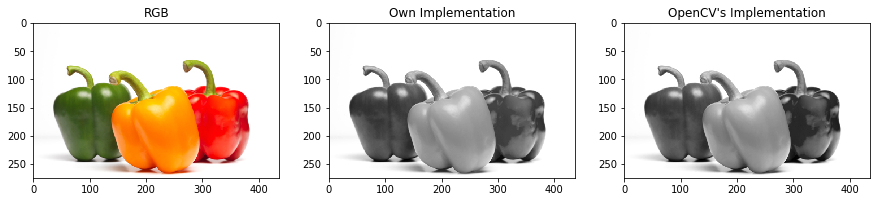

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage import color
import math

def rgb2gray(img):
    h = img.shape[0]
    w = img.shape[1]
    gray = np.zeros((h,w))
    
    for i in range(h):
        for j in range(w):
            gray[i,j] = 0.2989*img[i,j,0] + 0.587*img[i,j,1] + 0.114*img[i,j,2]
            
    return gray

sample_img = imread("3peppers.jpg")

gray_img = rgb2gray(sample_img)
gray2_img = color.rgb2gray(sample_img)

plt.figure(figsize=(15,7.5))
plt.subplot("131")
plt.title("RGB")
plt.imshow(sample_img)
plt.subplot("132")
plt.title("Own Implementation")
plt.imshow(gray_img, cmap="gray")
plt.subplot("133")
plt.title("OpenCV's Implementation")
plt.imshow(gray2_img, cmap="gray")
plt.show()

# Why not use CIE L\*a\*b instead?

Similar to retrieving the Luminance channel of NTSC. One could retrieve the Luminance channel of another color space such as CIE L*a*b.

To convert an RGB image to CIE L*a*b, RGB must first be converted to CIE XYZ. The XYZ tristimulus values, along with the intended white point and transfer function(s) (“gamma” curves) must be known. If there are not known, the sRGB color space values may be used. 



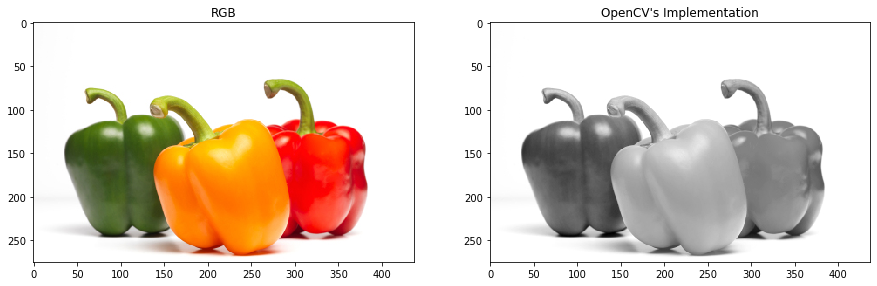

In [2]:
lab_img = color.rgb2lab(sample_img)
gray3_img = lab_img[:,:,0]

plt.figure(figsize=(15,7.5))
plt.subplot("121")
plt.title("RGB")
plt.imshow(sample_img)
plt.subplot("122")
plt.title("OpenCV's Implementation")
plt.imshow(gray3_img, cmap="gray")
plt.show()

# Are these good enough? How do we find out?

From a look, it can be said that a lot of information is lost when the colours are not present. It is now almost impossible to tell that all 3 peppers are actually different colours.

There are also scientific methods to measure the 'quality' of a grayscale image. It can tell us if a grayscale image still preserves contrasts and the preception of the original image.

[Martin Čadík](http://cadik.posvete.cz/color_to_gray_evaluation/) proposed a psychophysical method to evaluate decolorization methods. It is a method to understand what human vision perceives to be accurate decolorization. It also studies what human vision perceives to be a preferred decolorized image.

[Cewu Lu, Li Xu, Jiaya Jia](https://www.cse.cuhk.edu.hk/~leojia/projects/color2gray/index.html) proposed a quantitiave method that is validated using M. Cadik's work. They proposed Color Contrast Preserving Ratio (CCPR), Color Content Fidelity Ratio (CCFR) and a harmonic mean of those 2 which is called E-score.

In [3]:
# Code is ported from Authors MATLAB code.
# Authors are Cewu Lu, Li Xu and Jiaya Jia

def metric(im, IMGs, thrNum):
    n_IMGs = len(IMGs)
    
    a_ccpr = np.zeros((n_IMGs, thrNum))
    a_ccfr = np.zeros((n_IMGs, thrNum))
    a_escore = np.zeros((n_IMGs, thrNum))
    
    [colorContr_CCPR, colorContr_CCFR, t1, t2] = color_init(im)
    
    #print(colorContr_CCPR.shape)
    #print(colorContr_CCFR.shape)
    
    for jj in range(n_IMGs):
        #print(jj)
        imgt = IMGs[jj]
        [grayContr_CCPR, grayContr_CCFR] = gray_init(imgt, t1, t2)
        
        #print(grayContr_CCPR.shape)
        #print(grayContr_CCFR.shape)
        
        for thr in range(1, thrNum+1):
            ccpr = CCPR_fun_fast(colorContr_CCPR, grayContr_CCPR, thr)
            ccfr = CCFR_fun_fast(colorContr_CCFR, grayContr_CCFR, thr)
            E_score = 2*ccpr*ccfr/(ccpr+ccfr)

            a_ccpr[jj,thr-1] = ccpr
            a_ccfr[jj,thr-1] = ccfr
            a_escore[jj,thr-1] = E_score
    
    return a_ccpr, a_ccfr, a_escore

def color_init(im):
    np.random.seed(0)
    
    # CCPR
    n_im = im.shape[0]*im.shape[1]
    
    t1 = np.zeros((10*n_im), dtype=np.uint32)
    t2 = np.zeros((10*n_im), dtype=np.uint32)
    
    for ii in range(0, 10):
        t1[n_im*ii:n_im*(ii+1)] = np.random.permutation(np.arange(n_im))
        t2[n_im*ii:n_im*(ii+1)] = np.random.permutation(np.arange(n_im))
    
    imLab = color.rgb2lab(im)
    l = imLab[:,:,0]
    a = imLab[:,:,1]
    b = imLab[:,:,2]
    
    imV = np.array([l.ravel(), a.ravel(), b.ravel()])
    imV = imV.T
    
    colorContr_CCPR = np.sqrt(np.sum((imV[t1,:]-imV[t2,:])**2, 1))
    
    # CCFR
    k1 = np.array([1,-1])
    dLx = abs(cv.filter2D(imLab[:,:,0], -1, k1))**2
    dAx = abs(cv.filter2D(imLab[:,:,1], -1, k1))**2
    dBx = abs(cv.filter2D(imLab[:,:,2], -1, k1))**2
    dCx = np.sqrt(dLx + dAx + dBx); 
    
    k2 = np.array([[1],[-1]])
    dLy = abs(cv.filter2D(imLab[:,:,0], -1, k2))**2
    dAy = abs(cv.filter2D(imLab[:,:,1], -1, k2))**2
    dBy = abs(cv.filter2D(imLab[:,:,2], -1, k2))**2
    dCy = np.sqrt(dLy + dAy + dBy); 

    colorContr_CCFR = np.append(dCx.ravel(), dCy.ravel())
    
    #print("colorContr_CCPR: " + str(colorContr_CCPR.shape))
    #print("colorContr_CCFR: " + str(colorContr_CCFR.shape))
    #np.savetxt("colorContr_CCPR.csv", colorContr_CCPR)
    #np.savetxt("colorContr_CCFR.csv", colorContr_CCFR)
    
    return colorContr_CCPR, colorContr_CCFR, t1, t2
    
def gray_init(img, t1, t2):
    # CCPR
    img = color.rgb2gray(img)
    imgG = img * 100
    imgV = imgG.ravel()
    grayContr_CCPR = abs(imgV[t1] - imgV[t2])
    
    #print("grayContr_CCPR: " + str(grayContr_CCPR.shape))
    #np.savetxt("grayContr_CCPR.csv", grayContr_CCPR)
    
    # CCFR
    k1 = np.array([1,-1])
    k2 = np.array([[1],[-1]])
    dGx = abs(cv.filter2D(imgG, -1, k1))
    dGy = abs(cv.filter2D(imgG, -1, k2))
    grayContr_CCFR = np.append(dGx.ravel(), dGy.ravel())
    
    #print("grayContr_CCFR: " + str(grayContr_CCFR.shape))
    #np.savetxt("grayContr_CCFR.csv", grayContr_CCFR)
    
    return grayContr_CCPR, grayContr_CCFR
    
def CCPR_fun_fast(colorContr_CCPR, grayContr_CCPR, thr):
    color_local, = np.where(colorContr_CCPR > thr)
    gray_local, = np.where(grayContr_CCPR[color_local] > thr)
    ccpr = len(gray_local)/(len(color_local) + isempty(color_local))
    
    return ccpr
    
def CCFR_fun_fast(colorContr_CCFR, grayContr_CCFR, thr):
    gray_locate, = np.where(grayContr_CCFR > thr)
    color_locate, = np.where(colorContr_CCFR[gray_locate] < thr)
    ccfr = 1-len(color_locate)/(len(gray_locate) + isempty(gray_locate))
    
    return ccfr
    
def im2double(im, min_val, max_val):    
    return (im.astype('float') - min_val) / (max_val - min_val)
    
def isempty(arr):
    if arr.size == 0:
        return 1
    else:
        return 0

thrNum = 40 # number of threshold we considered
imNum = 250 # number of images
CCPR = np.zeros((6,thrNum))
CCFR = np.zeros((6,thrNum))
Escore = np.zeros((6,thrNum))

for ii in range(1, imNum+1):
    IMGs = []
    im = imread('COLOR250/images/'+str(ii)+'.png')
    im = im[:,:,0:2]
    
    img1 = imread('COLOR250/images/'+str(ii)+'_1.png')
    img2 = imread('COLOR250/images/'+str(ii)+'_2.png')
    img3 = imread('COLOR250/images/'+str(ii)+'_3.png')
    img4 = imread('COLOR250/images/'+str(ii)+'_4.png')
    img5 = imread('COLOR250/images/'+str(ii)+'_5.png')
    img6 = imread('COLOR250/images/'+str(ii)+'_6.png')

    IMGs.append(img1)
    IMGs.append(img2)
    IMGs.append(img3)
    IMGs.append(img4)
    IMGs.append(img5)
    IMGs.append(img6)
    [ccpr_m, ccfr_m, escore_m] = metric(im, IMGs, thrNum)
    
    CCPR = CCPR + 1/imNum*ccpr_m
    CCFR = CCFR + 1/imNum*ccfr_m
    Escore = Escore + 1/imNum*escore_m
    
np.savetxt("debug/CCPR.csv", CCPR)
np.savetxt("debug/CCFR.csv", CCFR)
np.savetxt("debug/Escore.csv", Escore)

plt.figure(figsize=(16,12))
plt.subplot('221')
plt.title('CCPR')
plt.plot(CCPR.T)
plt.subplot('222')
plt.title('CCFR')
plt.plot(CCFR.T)
plt.subplot('223')
plt.title('Escore')
plt.plot(Escore.T)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'COLOR250/images/1.png'